In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from catboost import Pool, CatBoostClassifier, cv
pd.options.display.max_columns
pd.set_option('display.max_columns', None)

# Data Prep

In [6]:
X_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/X_train.csv', index_col='id')
y_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/y_train.csv', squeeze=True)
X_test = pd.read_csv ('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/X_test.csv')

In [7]:
df = X_train

df = df.drop(['v_screening_date'], axis=1) # duplicate of 'screening_date'
df = df.drop(['v_type_of_assessment'], axis=1) # duplicate of 'type_of_assessment'
df = df.drop(['type_of_assessment'], axis=1) # 0 variance

df['target'] = y_train.to_list() # set target row-wise (ignoring indices)

In [8]:
# Engineer a new targets 
df['target_int'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 2}) # so we can do regression
df['target_bool'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 1}) # 0 - no-rec, 1 - rec
target_cols = ['target', 'target_int', 'target_bool']

In [9]:
df.columns

Index(['name', 'first', 'last', 'sex', 'date_of_birth', 'age', 'age_group',
       'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_offense_date', 'c_arrest_date', 'c_charge_degree', 'c_charge_desc',
       'r_jail_in', 'r_jail_out', 'screening_date', 'in_custody',
       'out_custody', 'start', 'target', 'target_int', 'target_bool'],
      dtype='object')

In [10]:
# Engineer new date based features

"""
Custody: when someone is kept in prison until they go to court
Screening:  involves  using  a  brief  instrument  to  quickly  capture basic information 
    about a person’s risk to reoffend and is  used  to  determine  if  a  more  comprehensive  assessment
    is  warranted.  In  a  jail  setting,  everyone,  regardless  of  legal  status, should be screened 
    at booking.  Risk  screening  divides  the  jail  population  into  high-,  medium-,  and  low-risk 
    categories,  making  it  possible  to  direct  intervention  resources  first  to  the highest-risk individuals.



- c_arrest_date and c_offense_date are mutually exclusive and one of them is 99.8% likely to be filled
- c_arrest_date and c_are mutually exclusive
- start is number of days between c_jail_in and c_jail_out, maybe worth engineering total hours/minutes between
- screening_date is always filled
"""



days_cols = []

def days_between(d1, d2):
    try:
        try:
            d1 = datetime.strptime(d1, "%Y-%m-%d")
        except ValueError:
            d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
            
        try:
            d2 = datetime.strptime(d2, "%Y-%m-%d")
        except ValueError:
            d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
        return abs((d2 - d1).days)
    except TypeError as e:
        return None

# mutually exclusive and one of them is always filled
df['c_bad_date'] = df['c_arrest_date'].fillna(df['c_offense_date']).fillna(df['in_custody']).fillna(df['screening_date'])

# how many days in custody
df['custody_days'] = df.apply(lambda x: days_between(x.out_custody, x.in_custody), axis=1)

# how quickly after going into custody did the person get screened (might indicate something?)
df['in_custody_to_screening_days'] = df.apply(lambda x: days_between(x.in_custody, x.screening_date), axis=1)

# questionable col because it is age related... Also corr=1 with age
df['birth_to_bad_days'] = df.apply(lambda x: days_between(x.date_of_birth, x.c_bad_date), axis=1)

# How many days passed until recitivism occcured. Golden feature!
df['days_until_recitivism'] = df.apply(lambda x: days_between(x.c_jail_out, x.r_jail_in), axis=1)

date_cols = [ 
    'c_arrest_date', 
    'c_offense_date',
    'screening_date', 
    'in_custody', 
    'out_custody', 
    'date_of_birth',
    'c_jail_in',
    'c_jail_out',
    'r_jail_in',
    'r_jail_out',

    # engineered
    'c_bad_date'
]

duration_cols = [
    'days_b_screening_arrest',
    'custody_days',
    'in_custody_to_screening_days',
    'birth_to_bad_days',
    'days_until_recitivism',
]

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,No-Recidivism,0,0,2013-09-23,4.0,1.0,7147,NaN
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,Violent,2,1,2013-06-15,0.0,1.0,6713,NaN
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,Non-Violent,1,1,2013-10-11,4.0,1.0,10776,66.0
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,No-Recidivism,0,0,2014-01-11,1.0,1.0,10236,NaN
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,No-Recidivism,0,0,2013-03-21,NaN,NaN,9445,NaN


In [11]:
# Has recidivism occured?
df['has_r_jail_in'] = df['r_jail_in'].notna()
df['has_r_jail_out'] = df['r_jail_out'].notna()

In [12]:
# fill missing values
df['c_charge_desc'] = df['c_charge_desc'].fillna('missing') 

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism,has_r_jail_in,has_r_jail_out
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,No-Recidivism,0,0,2013-09-23,4.0,1.0,7147,NaN,False,False
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,Violent,2,1,2013-06-15,0.0,1.0,6713,NaN,False,False
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,Non-Violent,1,1,2013-10-11,4.0,1.0,10776,66.0,True,True
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,No-Recidivism,0,0,2014-01-11,1.0,1.0,10236,NaN,False,False
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,No-Recidivism,0,0,2013-03-21,NaN,NaN,9445,NaN,False,False


In [13]:
cols = [
#     'name', useless
#     'first', useless
#     'last', useless
#     'sex', # 0 importance + potential bias
#     'date_of_birth', date
#     'age', # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
    'juv_fel_count',
    'juv_misd_count', 
    'juv_other_count',
    'priors_count', 
    'days_b_screening_arrest',
#     'c_jail_in', date
#     'c_jail_out',date
#     'c_offense_date', date
#     'c_arrest_date', date
#     'c_charge_degree',  # 0 importance
    'c_charge_desc',
#     'r_jail_in', date
#     'r_jail_out', date
#     'screening_date', date
#     'in_custody', date
#     'out_custody', date
    'start', 
#     'target', target
#     'target_int', target
#     'target_bool', target
#     'c_bad_date', date
    'custody_days',
    'in_custody_to_screening_days',
#     'birth_to_bad_days', # corr=1 with age
    'has_r_jail_in', 
#     'has_r_jail_out', # corr=1 with r_jail_in
    'days_until_recitivism', # golden feature!
]

cat_cols = [
#     'sex',  # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'c_charge_degree', # 0 importance
    'c_charge_desc',
]

<AxesSubplot:>

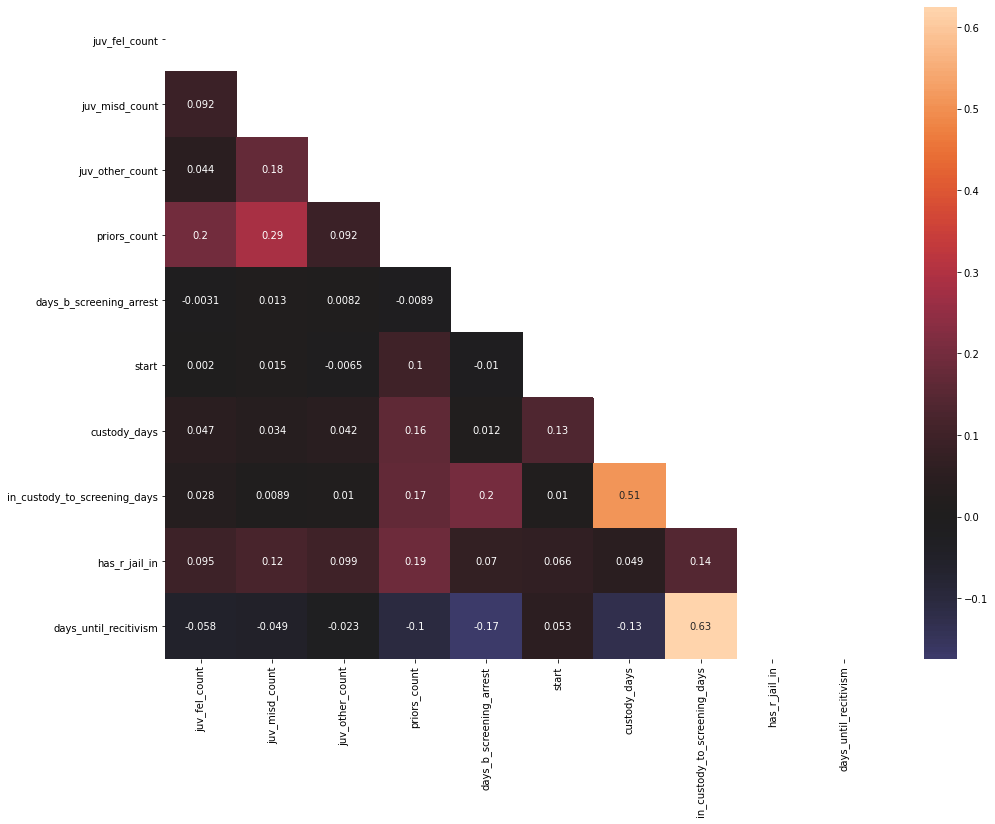

In [14]:
# Numeric correlations across numeric features
f, ax = plt.subplots(figsize=(16, 12))
corr = df[cols].corr()
mask = np.triu(corr)
sns.heatmap(corr.select_dtypes('number'), annot=True, center=0, mask=mask)

In [15]:
df[cols].head()

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_desc,start,custody_days,in_custody_to_screening_days,has_r_jail_in,days_until_recitivism
id,,,,,,,,,,,
2677,0,0,0,2,-1.0,arrest case no charge,3,4.0,1.0,False,NaN
548,0,1,0,1,-1.0,Grand Theft in the 3rd Degree,0,0.0,1.0,False,NaN
4483,0,0,0,6,-1.0,Grand Theft in the 3rd Degree,3,4.0,1.0,True,66.0
9476,0,0,0,3,-1.0,Felony Driving While Lic Suspd,0,1.0,1.0,False,NaN
199,0,0,0,2,NaN,arrest case no charge,0,NaN,NaN,False,NaN


In [16]:
races = df.race.unique()
sexes = df.sex.unique()
age_groups = df.age_group.unique()

# Cross Validation

In [17]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections

kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(df[cols], df['target'], test_size=0.2)

roc_aucs = []
roc_aucs_race = collections.defaultdict(list)
roc_aucs_age = collections.defaultdict(list)
roc_aucs_sex = collections.defaultdict(list)

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df[cols], df['race'])): # Stratified on race
    train_df = df.iloc[train].reset_index(drop=True)
    eval_df = df.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=train_df[cols],
                         label=train_df.target,
                         cat_features=cat_cols)

    eval_dataset = Pool(data=eval_df[cols],
                        label=eval_df.target,
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(eval_df.target).to_numpy()
    
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10,
                               learning_rate=1,
                               depth=2,
                               loss_function='MultiClass')
    # Fit model
    model.fit(train_dataset, verbose=False)
    # Get predicted classes
    preds_class = model.predict(eval_dataset)
    # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
    # Get predicted RawFormulaVal
    preds_raw = model.predict(eval_dataset, 
                              prediction_type='RawFormulaVal')
    
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    roc_aucs.append(roc_auc)
    for race in races:
        eval_race_df = eval_df[eval_df['race'] == race]
        try:
            roc_aucs_race[race].append(roc_auc_score(y_eval[eval_race_df.index], preds_proba[eval_race_df.index], multi_class="ovo"))
        except Exception as e:
            pass
    
    for sex in sexes:
        eval_sex_df = eval_df[eval_df['sex'] == sex]
        try:
            roc_aucs_sex[sex].append(roc_auc_score(y_eval[eval_sex_df.index], preds_proba[eval_sex_df.index], multi_class="ovo"))
        except Exception as e:
            pass
        
    for age in age_groups:
        eval_age_df = eval_df[eval_df['age_group'] == age]
        try:
            roc_aucs_age[age].append(roc_auc_score(y_eval[eval_age_df.index], preds_proba[eval_age_df.index], multi_class="ovo"))
        except Exception as e:
            pass
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    print(f'Split {split_idx+1}: ROC-AUC: {roc_auc*100:.2f}%')

Split 1: ROC-AUC: 87.09%
Split 2: ROC-AUC: 86.67%
Split 3: ROC-AUC: 90.36%
Split 4: ROC-AUC: 84.42%
Split 5: ROC-AUC: 87.65%
Split 6: ROC-AUC: 87.02%
Split 7: ROC-AUC: 85.39%
Split 8: ROC-AUC: 85.36%
Split 9: ROC-AUC: 91.10%
Split 10: ROC-AUC: 86.83%
Split 11: ROC-AUC: 89.48%
Split 12: ROC-AUC: 91.83%
Split 13: ROC-AUC: 86.55%
Split 14: ROC-AUC: 85.53%
Split 15: ROC-AUC: 83.70%
Split 16: ROC-AUC: 84.07%
Split 17: ROC-AUC: 88.29%
Split 18: ROC-AUC: 87.30%
Split 19: ROC-AUC: 86.87%
Split 20: ROC-AUC: 89.97%
Split 21: ROC-AUC: 89.62%
Split 22: ROC-AUC: 87.84%
Split 23: ROC-AUC: 87.65%
Split 24: ROC-AUC: 87.50%
Split 25: ROC-AUC: 87.16%
Split 26: ROC-AUC: 89.69%
Split 27: ROC-AUC: 89.25%
Split 28: ROC-AUC: 87.91%
Split 29: ROC-AUC: 87.41%
Split 30: ROC-AUC: 88.02%
Split 31: ROC-AUC: 90.85%
Split 32: ROC-AUC: 89.87%
Split 33: ROC-AUC: 83.63%
Split 34: ROC-AUC: 89.66%
Split 35: ROC-AUC: 82.38%
Split 36: ROC-AUC: 89.35%
Split 37: ROC-AUC: 84.78%
Split 38: ROC-AUC: 89.60%
Split 39: ROC-AUC: 86

In [18]:
# Evaluation
print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}%')

# Calculate ROC-AUC mean per subset
mean_roc_aucs_race = dict()
mean_roc_aucs_sex = dict()
mean_roc_aucs_age = dict()

for race, aucs in roc_aucs_race.items():
    mean_roc_aucs_race[race] = np.mean(aucs)
for sex, aucs in roc_aucs_sex.items():
    mean_roc_aucs_sex[sex] = np.mean(aucs)
for age, aucs in roc_aucs_age.items():
    mean_roc_aucs_age[age] = np.mean(aucs)

# Calculate ROC-AUC standard deviation per subset
race_std = np.std([x for x in mean_roc_aucs_race.values() if np.isfinite(x)])
sex_std = np.std([x for x in mean_roc_aucs_sex.values() if np.isfinite(x)])
age_std = np.std([x for x in mean_roc_aucs_age.values() if np.isfinite(x)])

print(race_std)
# Calculate fairness per subset
race_fairness = 1 - np.sqrt(race_std)
sex_fairness = 1 - np.sqrt(sex_std)
age_fairness = 1 - np.sqrt(age_std)

print(f'Race fairness: {race_fairness*100:.2f}%')
print(f'Sex fairness: {sex_fairness*100:.2f}%')
print(f'Age fairness: {age_fairness*100:.2f}%')

ROC-AUC 87.65%
0.05263019539290935
Race fairness: 77.06%
Sex fairness: 91.04%
Age fairness: 88.01%


/mnt/c/Users/emmar/Documents/Projects/Caggle/compas-comp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/c/Users/emmar/Documents/Projects/Caggle/compas-comp/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:ylabel='race'>

<AxesSubplot:ylabel='sex'>

<AxesSubplot:ylabel='age'>

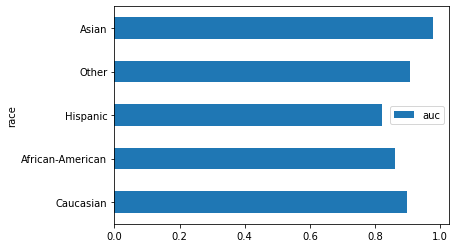

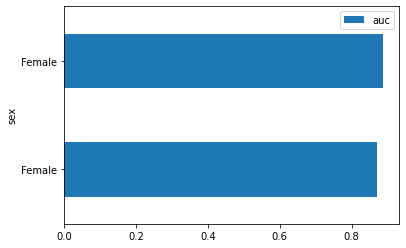

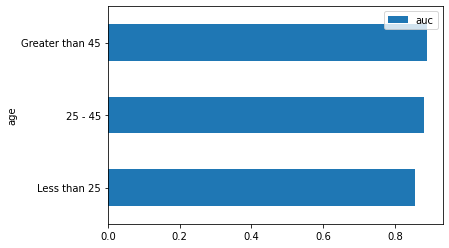

In [19]:
race_auc_df = pd.DataFrame({'race': races, 'auc': [mean_roc_aucs_race[race] for race in races]})
sex_auc_df = pd.DataFrame({'sex': sex, 'auc': [mean_roc_aucs_sex[sex] for sex in sexes]})
age_auc_df = pd.DataFrame({'age': age_groups, 'auc': [mean_roc_aucs_age[age] for age in age_groups]})
                     
display(race_auc_df[race_auc_df['auc'].notna()].plot.barh(x='race'))
display(sex_auc_df[sex_auc_df['auc'].notna()].plot.barh(x='sex'))
display(age_auc_df[age_auc_df['auc'].notna()].plot.barh(x='age'))

,feature,importance,std,min,max
10,days_until_recitivism,39.193160,7.839663,29.928631,77.814538
9,has_r_jail_in,26.429345,5.580602,7.808612,35.872101
3,priors_count,17.373627,4.042829,6.913927,26.113349
1,juv_misd_count,3.627048,1.846879,0.000000,8.018153
7,custody_days,3.246475,2.483156,0.000000,10.038685
2,juv_other_count,3.077727,2.250397,0.000000,7.785984
8,in_custody_to_screening_days,2.538488,2.746809,0.000000,11.168094
4,days_b_screening_arrest,2.222524,1.531439,0.075452,7.326746
6,start,2.034769,2.313533,0.000000,8.068800
5,c_charge_desc,0.165083,0.502642,0.000000,2.107924


<AxesSubplot:ylabel='feature'>

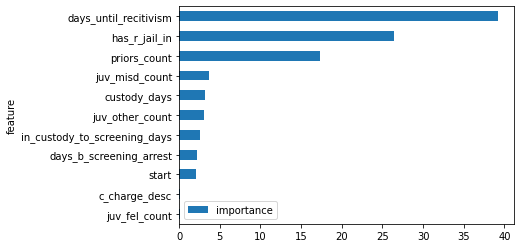

In [20]:
# Feature importances
fi_df = pd.DataFrame({'feature': cols})
fi_df['importance'] = np.mean(feature_importances, axis=0)
fi_df['std'] = np.std(feature_importances, axis=0)
fi_df['min'] = np.min(feature_importances, axis=0)
fi_df['max'] = np.max(feature_importances, axis=0)
fi_df = fi_df.sort_values('importance', ascending=False)
display(fi_df)
display(fi_df[['feature', 'importance']].sort_values('importance', ascending=True).plot.barh(x='feature'))